In [1]:
%matplotlib qt5
import hyperspy.api as hs
import numpy as np
import matplotlib.pyplot as plt
from skimage import filters, transform
from scipy import ndimage

Use the shift_params if the corners detected are not exactly where you want them to be. 

In [2]:
shift_params = np.array([
        [1, 2], # Top-left corner
        [-1, 1], # Top-right corner
        [4, -3], # Bottom-left corner
        [-3, -1]  # Bottom-right corner
    ])

In [3]:
def bf_to_binary(bf, sigma_gauss=0.5):
    
    # Turn into an array
    bf_data = bf.data

    # Make a threshold and turn image to binary. By this the ourside film gets turned into one color
    threshold = filters.threshold_otsu(bf_data)
    binary = (bf_data < threshold)

    # Apply gaussian blur to remove noise
    blurred = filters.gaussian(binary, sigma=sigma_gauss)
    new_binary = (blurred < 0.9999999)

    return new_binary


In [4]:
def rotate_binary(binary, rot_angle=45, sigma_gauss=0.5):
    # It is easier to detect the corners by doing a scan from all edges of the image. 
    # It is then again easier to detect sharp corners.


    # Rotate the image, and have to remove new noise that is created
    binary_rotated = ndimage.rotate(binary, rot_angle)
    rotated_blurred = filters.gaussian(binary_rotated, sigma=sigma_gauss)
    binary_final = (rotated_blurred < 0.1)

    # Turn it into boolean
    binary_final = binary_final.astype(bool)
    return binary_final


In [5]:
def detect_corners(bf, sigma_gauss=0.5, rot_angle=45):
    # Detect the corners by a scan. Rot angle is to rotate the square ASI padding.


    # Create a binary rotated image for easy corner detection
    binary_image = bf_to_binary(bf, sigma_gauss=sigma_gauss)
    rotated_image = rotate_binary(binary_image, sigma_gauss=sigma_gauss, rot_angle=rot_angle)

    # Check if image is correctly inverted. If not, invert
    if rotated_image[0,0] == True:
        rotated_image = ~rotated_image

    # Create a scanning pixel to determine if we detect a change in contrast.
    x, y = rotated_image.shape
    scanner = False
    corners = []


    # Top-right corner
    for i in range(0, x):
        for j in range(0, y):
            scanner = rotated_image[j, i]
            if scanner == True:
                corners.append([i, j])
                break
        if len(corners) > 0:
            break
    
    # Top-left corner
    for j in range(0, y):
        for i in range(x-1, 0, -1):
            scanner = rotated_image[j, i]
            if scanner == True:
                corners.append([i, j])
                break
        if len(corners) > 1:
            break

    # Bottom-left corner
    for j in range(y-1, 0, -1):
        for i in range(x-1, 0, -1):
            scanner = rotated_image[j, i]
            if scanner == True:
                corners.append([i, j])
                break
        if len(corners) > 2:
            break

    

    # Bottom-right corner
    for i in range(x-1, 0, -1):
        for j in range(0, y):
            scanner = rotated_image[j, i]
            if scanner == True:
                corners.append([i, j])
                break
        if len(corners) > 3:
            break

        
    binary_shape = binary_image.shape
    rotated_shape = rotated_image.shape

    # Define the 45-degree rotation matrix
    angle = np.radians(rot_angle)
    cos_angle = np.cos(angle)
    sin_angle = np.sin(angle)

    rotation_matrix = np.array([
        [cos_angle, -sin_angle],
        [sin_angle, cos_angle]
    ])

    # Define rotation origin
    x1, y1 = rotated_shape

    center_of_rotation1 = np.array([x1/2, y1/2])

    rotated_corners = []

    corners -= center_of_rotation1

    for corner in corners:
        rotated_corner = np.dot(rotation_matrix, corner)
        rotated_corners.append(rotated_corner)

    rotated_corners += center_of_rotation1
    rotated_corners = rotated_corners*binary_shape/rotated_shape

    x2, y2 = binary_shape

    center_of_rotation2 = np.array([x2/2, y2/2])

    rotated_corners -= center_of_rotation2

    rotated_corners[0] = rotated_corners[0]*rotated_shape/binary_shape
    rotated_corners[1] = rotated_corners[1]*rotated_shape/binary_shape
    rotated_corners[2] = rotated_corners[2]*rotated_shape/binary_shape
    rotated_corners[3] = rotated_corners[3]*rotated_shape/binary_shape

    rotated_corners += center_of_rotation2

    return rotated_corners



In [6]:
def transform_bitmap(bmp_data, bf, shift_params=np.zeros((4,2)).astype(int)):
    data = bmp_data
    height, width = data.shape[:2]
    output_shape = bf.data.shape

    # Define the source points (corners of the original bitmap)
    src_points = np.array([
        [0, 0],          # Top-left corner
        [width, 0],      # Top-right corner
        [0, height],     # Bottom-left corner
        [width, height]  # Bottom-right corner
    ], dtype=np.float32)

    corners = detect_corners(bf)

    x0, y0 = corners[0]
    x1, y1 = corners[1]
    x2, y2 = corners[2]
    x3, y3 = corners[3]

    dst_points = np.array([[x0+shift_params[0][0], y0+shift_params[0][1]], # Top-left
        [x1+shift_params[1][0], y1+shift_params[1][1]], # Top-right
        [x2+shift_params[2][0], y2+shift_params[2][1]], # Bottom-left
        [x3+shift_params[3][0], y3+shift_params[3][1]]  # Bottom-right
    ])

    tform = transform.ProjectiveTransform()
    tform.estimate(src_points, dst_points)
    transformed_image = transform.warp(data, tform.inverse, output_shape=output_shape)

    return transformed_image

In [7]:
def create_descan_mask(bf):
    # De-scan correction is wrong when done over magnetic domains of different directions.
    # We therefore have to mask out the surrounding film in the image 
    # This function creates the mask by finding the minimum and maximum x- and y-values
    # and use a 20 pixel padding. This parameter might have to be changed for a different image shape.

    bf_shape = bf.data.shape
    corners = detect_corners(bf)

    mini_x = np.min(corners, 0)[1].astype(int)
    mini_y = np.min(corners, 0)[0].astype(int)
    maxi_x = np.max(corners, 0)[1].astype(int)
    maxi_y = np.max(corners, 0)[0].astype(int)
    
    s_mask = hs.signals.Signal2D(np.ones(bf_shape, dtype=bool))
    s_mask.data[mini_x+20:maxi_x-20, mini_y+20:maxi_y-20] = False
    return s_mask

Start by loading the signal. This is a .zspy file to get the signal to work quick. Important to include lazy=True to not crash the PC for large files.

In [8]:
s = hs.load('005_3nm_55rot_512x512_4length_0time.zspy', lazy=True)

S_nav is a brightfield (bf) image of the structure. We need this later for corner detection.

In [9]:
s_sum = s.sum(axis=(-1,-2))
s_nav = s_sum.transpose()
s_nav.compute()
s.navigator = s_nav

[########################################] | 100% Completed | 4.67 sms


Checking the shape of the signal. One flyback pixel is included, thus we have 513x512 pixels instead of the recorded 512x512 pixels. The 80x80 is in the reciprocal space and has been cropped from 256x256 pixels because the probe was small and did not move alot during the scan.

In [10]:
s.plot(colorbar=False, scalebar=False, axes_ticks=False, title='', axes_off=True)

For an uncropped reciprocal room you can use the .isig function. For further work, use the s_crop signal rather than the s signal

In [11]:
"""s_crop = s.isig[:,:]
s_crop.navigator = s_nav"""


's_crop = s.isig[:,:]\ns_crop.navigator = s_nav'

Turn the signal to a BeamShift signal with the same dimensions in pixel space, but only two dimensions in reciprocal space.

In [12]:
s.compute()
s_com = s.center_of_mass()
s_bs = s_com.to_beamshift()
s_bs

[########################################] | 100% Completed | 2.48 sms
[########################################] | 100% Completed | 18.88 s


<BeamShift, title: , dimensions: (513, 512|2)>

By plotting the signal, we see that the total image includes some magnetic film outside the milled structure.

We now want to make a linear plane to remove de-scan in the image. The problem is that the linear plane is made from only the outer pixels of the image, and these are affected by the magnetic film. This would lead to a linear plane with either a too high or too low gradient. We therefore have to mask out the signal such that the linear plane is made from the padding around the ASI that has lost its magnetic contrast during milling. If the structure is rotated, you have to rotate before the masking.

Use the de-scan mask-function

In [13]:
s_mask = create_descan_mask(s_nav)

We now make a linear plane using the mask. Now we only make the descan from pixels within the ASI padding area

In [14]:
s_bs_linear_plane = s_bs.deepcopy()
s_bs_linear_plane.make_linear_plane(mask=s_mask)

By subtracting the linear plane from the BeamShift signal we get a signal with de-scan removed

In [15]:
s_bs_corr = s_bs - s_bs_linear_plane

Then we turn the BeamShift signal into a DPCSignal2D signal of the original image dimensions.

In [16]:
s_dpc = s_bs_corr.to_dpcsignal()

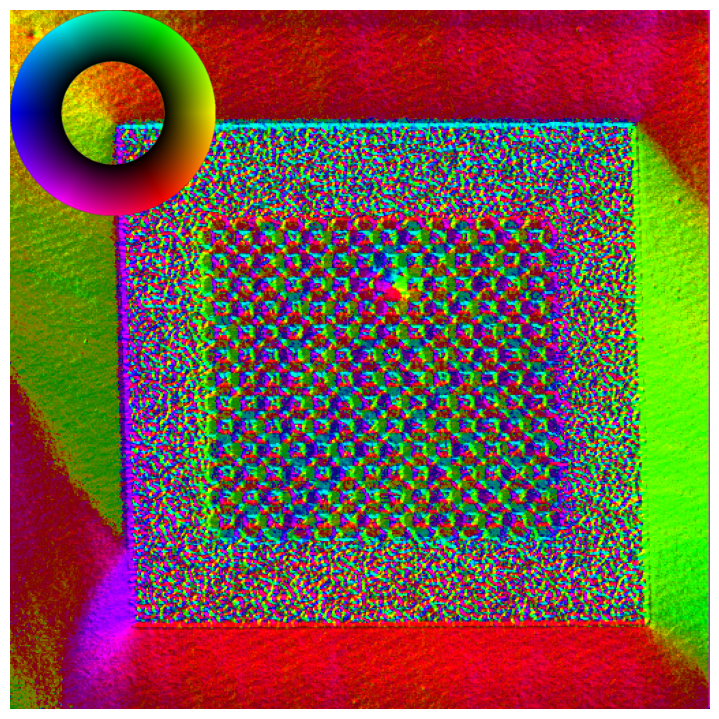

In [17]:
s_dpc.get_color_image_with_indicator(autolim_sigma=0.5)

We make a color signal as a Signal2D signal. Use autolim_sigma= to get higher contrast. This value can be changed for thicker or thinner films.

In [18]:
s_color = s_dpc.get_color_signal(autolim_sigma=0.5)
s_color

<Signal2D, title: , dimensions: (|513, 512)>

We now want to turn the signal into a RGB-numpy array as it is easier to work with.

In [19]:
s_color.change_dtype("uint16")
s_color.change_dtype("float64")
data_rgb = s_color.data
data_rgb.shape

(512, 513, 3)

In [20]:
data_rgb

array([[[64025., 56502.,     0.],
        [60923., 50081.,     0.],
        [48611., 34805.,     0.],
        ...,
        [53936.,     0., 29902.],
        [53868.,     0., 34981.],
        [65535.,     0., 59683.]],

       [[65535., 57600.,     0.],
        [63016., 52980.,     0.],
        [59720., 46240.,     0.],
        ...,
        [57305.,     0., 31688.],
        [48873.,     0., 19901.],
        [65535.,     0., 59812.]],

       [[60704., 60436.,     0.],
        [64640., 65535.,     0.],
        [52373., 51513.,     0.],
        ...,
        [40703.,     0., 13428.],
        [54466.,     0., 30556.],
        [65535.,     0., 59565.]],

       ...,

       [[ 5405., 34124.,     0.],
        [15161., 34124.,     0.],
        [ 5598., 34124.,     0.],
        ...,
        [34124.,     0.,  9559.],
        [34124.,     0., 23944.],
        [63497.,     0., 65535.]],

       [[15609., 34124.,     0.],
        [ 5532., 34124.,     0.],
        [ 7726., 34124.,     0.],
        .

In [21]:
fig, ax = plt.subplots()
ax.imshow(data_rgb / 65536.0)

Adding extent and plotting the RGB data

In [22]:
extent = s.axes_manager.signal_extent
extent = [extent[0], extent[1], extent[3], extent[2]]

Load the bitmap used in the RGB image

In [23]:
bitmap = hs.load('bitmaps/Sq_size(512, 512)_elongation8_spacing11.bmp')

In [24]:
#bitmap = bitmap.data

In [25]:
bitmap = transform.rotate(bitmap.data, 90)


Transform the mask onto the data. Might have to change some parameters in the transform_bitmap function

In [26]:
transformed_image = transform_bitmap(bitmap, s_nav, shift_params=shift_params)

In [27]:
corns = detect_corners(s_nav)

x0, y0 = corns[0]
x1, y1 = corns[1]
x2, y2 = corns[2]
x3, y3 = corns[3]

corners = np.array([[x0+shift_params[0][0], y0+shift_params[0][1]], # Top-left
    [x1+shift_params[1][0], y1+shift_params[1][1]], # Top-right
    [x2+shift_params[2][0], y2+shift_params[2][1]], # Bottom-left
    [x3+shift_params[3][0], y3+shift_params[3][1]]  # Bottom-right
])
with open('corners_data/002_3nm_55rot_512x512_tx21_corners.npy', 'rb') as f:
    corners = np.load(f)

Make all bitmap-pixels black

In [28]:
data_rgb[transformed_image.astype(bool)] = np.array([0., 0., 0.])

In [29]:
fig, ax = plt.subplots()
ax.imshow(data_rgb / 65536.0)

In [30]:
ax.set_xticks([])
ax.set_yticks([])

[]

In [31]:
#fig.savefig('002_3nm_55rot_512x512_tx21.png', bbox_inches='tight', dpi=1000)

In [32]:
#with open('002_3nm_55rot_512x512_tx21.npy', 'wb') as f:
#    np.save(f, data_rgb/65535.0)

In [33]:
#with open('001_3nm_55rot_512x512_tx16_corners.npy', 'wb') as f:
#    np.save(f, corners)
